In [1]:
import os

adr_nbbo_dir = os.path.join('../data/raw/adrs/bbo-1m/nbbo')
etf_nbbo_dir = os.path.join('../data/raw/etfs/market/bbo-1m/nbbo')
adr_info_filename = os.path.join('..', 'data', 'raw', 'adr_info.csv')
futures_symbols_filename = os.path.join('../data/raw/futures_symbols.csv')
signal_dir = os.path.join('..', 'data', 'processed', 'futures_only_signal')
close_filename = os.path.join('..', 'data', 'raw', 'adrs', 'adr_PX_LAST_adjust_none.csv')
domestic_close_mid_filename = os.path.join('..', 'data', 'processed', 'adrs', 'adr_mid_at_ord_auction_adjust_none.csv')
hedge_ratio_filename = os.path.join('..', 'data', 'processed', 'market_etf_hedge_ratios.csv')
etf_filename = os.path.join('..', 'data', 'raw', 'etfs', 'market', 'market_etf_PX_LAST_adjust_none.csv')

In [2]:
import pandas as pd

close_df = pd.read_csv(close_filename, index_col=0, parse_dates=True)
dom_close_df = pd.read_csv(domestic_close_mid_filename, index_col=0, parse_dates=True)
ratio_df = pd.read_csv(hedge_ratio_filename, index_col=0, parse_dates=True)
etf_close_df = pd.read_csv(etf_filename, index_col=0, parse_dates=True)
adr_info = pd.read_csv(adr_info_filename)
adr_info['adr_tickers'] = adr_info['adr'].str.replace(' US Equity','')
hedge_dict = adr_info.set_index('adr_tickers')['market_etf_hedge'].to_dict()

In [3]:
measured_time = [
                    '13:00:00',
                    '13:30:00',
                    '14:00:00',
                    '14:30:00',
                    '15:00:00',
                    '15:30:00',
                    '15:35:00',
                    '15:40:00',
                    '15:45:00',
            ]

In [4]:
asia_tickers = adr_info[adr_info['country'].isin(['JAPAN','AUSTRALIA'])]['adr'].str.replace(' US Equity','').tolist()

In [ ]:
import numpy as np

t0_for_cov  = '14:00:00'
all_daily = []
all_ic = {}
all_hedged_ic = {}
pre_25_ic = {}
post_25_ic = {}
post_25_hedged_ic = {}
for ticker in close_df.columns:
    hedge_ticker = hedge_dict[ticker]
    all_ic[ticker] = []
    all_hedged_ic[ticker] = []
    pre_25_ic[ticker] = []
    post_25_ic[ticker] = []
    post_25_hedged_ic[ticker] = []
    df = pd.read_parquet(os.path.join(adr_nbbo_dir, f'ticker={ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
    df['mid'] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    df['date'] = df.index.tz_localize(None).normalize()
    merged = df.merge(close_df[[ticker]].dropna().rename(columns={ticker: 'close'}), left_on='date', right_index=True)
    
    etf_df = pd.read_parquet(os.path.join(etf_nbbo_dir, f'ticker={hedge_ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
    etf_df['etf_mid'] = (etf_df['nbbo_bid'] + etf_df['nbbo_ask']) / 2
    merged = etf_df[['etf_mid']].merge(merged, left_index=True, right_index=True)
    merged = merged.merge(etf_close_df[[hedge_ticker]].dropna().rename(columns={hedge_ticker: 'etf_close'}), left_on='date', right_index=True,how='left')
    merged = merged.merge(ratio_df[[ticker]].dropna().rename(columns={ticker: 'hedge_ratio'}), left_on='date', right_index=True,how='left')

    signal_df = pd.read_parquet(os.path.join(signal_dir, f'ticker={ticker}'), columns=['signal'])
    merged = signal_df.merge(merged, left_index=True, right_index=True)
    for t0 in measured_time:
        daily = merged.between_time(t0, t0).copy()
        daily['adr_ret'] = (daily['close'] - daily['mid']) / daily['mid']
        daily['etf_ret'] = (daily['etf_close'] - daily['etf_mid']) / daily['etf_mid']
        daily['hedged_ret'] = daily['adr_ret'] - daily['hedge_ratio'] * daily['etf_ret']
        daily['signal'] = daily['signal'].clip(-0.01, 0.01)
        all_ic[ticker].append(daily['adr_ret'].corr(daily['signal']))
        all_hedged_ic[ticker].append(daily['hedged_ret'].corr(daily['signal']))
        pre_25_ic[ticker].append(daily.loc[:'2024','hedged_ret'].corr(daily.loc[:'2024','signal']))
        post_25_ic[ticker].append(daily.loc['2025':,'adr_ret'].corr(daily.loc['2025':,'signal']))
        post_25_hedged_ic[ticker].append(daily.loc['2025':,'hedged_ret'].corr(daily.loc['2025':,'signal']))
        if t0 == t0_for_cov:
            daily['ticker'] = ticker
            daily['date'] = daily.index.tz_localize(None).normalize()
            all_daily.append(daily[['ticker', 'date', 'hedged_ret','adr_ret','signal']])
        
    #print(f'Ticker: {ticker}, ICs: {np.mean(all_ic[ticker]):.3f} hedged ICs: {np.mean(all_hedged_ic[ticker]):.3f}')

    #print(f'Ticker: {ticker}, ICs: {np.mean(pre_25_ic[ticker]):.3f} hedged ICs: {np.mean(post_25_ic[ticker]):.3f}')
    print(f'Ticker: {ticker}, ICs: {np.mean(post_25_ic[ticker]):.3f} hedged ICs: {np.mean(post_25_hedged_ic[ticker]):.3f}')

daily_df = pd.concat(all_daily, ignore_index=True)
# Drop any duplicates based on date and ticker, keeping the first occurrence
daily_df = daily_df.drop_duplicates(subset=['date', 'ticker'], keep='first')
signal_daily = daily_df.pivot(index='date', columns='ticker', values='signal')
adr_ret_daily = daily_df.pivot(index='date', columns='ticker', values='adr_ret')
hedged_ret_daily = daily_df.pivot(index='date', columns='ticker', values='hedged_ret')


Ticker: PSO, ICs: 0.145 hedged ICs: 0.145
Ticker: NWG, ICs: 0.110 hedged ICs: 0.183
Ticker: AEG, ICs: 0.039 hedged ICs: 0.076
Ticker: MFG, ICs: 0.128 hedged ICs: 0.143
Ticker: UBS, ICs: 0.097 hedged ICs: 0.042
Ticker: LYG, ICs: 0.155 hedged ICs: 0.120
Ticker: RYAAY, ICs: -0.070 hedged ICs: -0.054
Ticker: RTO, ICs: 0.052 hedged ICs: 0.136
Ticker: FMS, ICs: 0.057 hedged ICs: 0.047
Ticker: VOD, ICs: 0.022 hedged ICs: 0.091
Ticker: BBVA, ICs: 0.115 hedged ICs: 0.081
Ticker: WDS, ICs: -0.075 hedged ICs: -0.075
Ticker: HMC, ICs: 0.083 hedged ICs: -0.051
Ticker: ASML, ICs: 0.044 hedged ICs: 0.089
Ticker: RIO, ICs: 0.092 hedged ICs: 0.113
Ticker: SMFG, ICs: 0.108 hedged ICs: 0.052
Ticker: NVO, ICs: 0.051 hedged ICs: 0.067
Ticker: BCS, ICs: 0.108 hedged ICs: 0.097
Ticker: RELX, ICs: -0.021 hedged ICs: -0.011
Ticker: DB, ICs: 0.127 hedged ICs: 0.070
Ticker: NGG, ICs: 0.083 hedged ICs: 0.146
Ticker: SONY, ICs: 0.053 hedged ICs: 0.053
Ticker: E, ICs: -0.086 hedged ICs: -0.105
Ticker: IHG, ICs: -0.

In [12]:
adr_info['adr'].str.replace(' US Equity', '')

0       TAK
1      SONY
2        TM
3       HMC
4      MUFG
5      SMFG
6       MFG
7       BUD
8       AEG
9      ARGX
10     ASML
11      AZN
12      BCS
13      BTI
14     BBVA
15      BHP
16       BP
17      DEO
18        E
19     EQNR
20     ERIC
21      FMS
22     GMAB
23      GSK
24      HLN
25     HSBC
26      IHG
27      ING
28      LYG
29      NGG
30      NOK
31      NVS
32      NVO
33      NWG
34      PHG
35      PUK
36      PSO
37     RELX
38      RIO
39      RTO
40    RYAAY
41      SNY
42      SAN
43      SAP
44     SHEL
45      SNN
46       TS
47      TTE
48      UBS
49       UL
50      VOD
51      WDS
52      WPP
53       DB
Name: adr, dtype: object

In [45]:
signal_daily

ticker,AEG,ARGX,ASML,AZN,BBVA,BCS,BHP,BP,BTI,BUD,...,SONY,TAK,TM,TS,TTE,UBS,UL,VOD,WDS,WPP
date,,,,,,,,,,,,,,,,,,,,,
2018-05-01,NaN,NaN,NaN,-0.003223,NaN,-0.000847,0.010000,-0.001941,0.001468,NaN,...,NaN,NaN,0.005943,NaN,NaN,NaN,0.000096,-0.001223,NaN,0.006532
2018-05-02,-0.000844,0.010000,-0.001183,0.000603,0.001574,-0.003833,-0.006454,-0.001900,0.002034,0.005664,...,NaN,NaN,0.000854,0.000620,NaN,0.000465,0.006428,-0.001033,NaN,0.005162
2018-05-03,-0.001313,-0.006720,-0.001739,0.001169,-0.000190,-0.001750,-0.002681,-0.002356,0.007414,-0.001414,...,NaN,NaN,NaN,-0.005017,NaN,-0.001341,0.002477,-0.000950,NaN,0.002161
2018-05-04,0.000566,-0.002975,-0.009686,0.007955,-0.001619,-0.004638,-0.010000,-0.000459,-0.002025,0.002285,...,NaN,NaN,NaN,-0.004537,NaN,0.002535,0.002190,0.003423,NaN,0.003648
2018-05-07,-0.000345,-0.001682,-0.002359,NaN,-0.000368,NaN,NaN,NaN,NaN,-0.000448,...,NaN,NaN,0.002615,-0.002421,NaN,-0.003628,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-10,0.008550,0.004348,-0.003498,-0.006492,0.001961,0.000451,NaN,-0.000874,0.000151,0.000461,...,NaN,NaN,NaN,0.001855,0.001642,0.007517,0.001693,0.000843,NaN,0.001576
2025-12-11,-0.001648,-0.002581,-0.007022,0.006845,0.002559,-0.002233,NaN,0.000322,0.001866,0.001199,...,NaN,NaN,NaN,-0.002971,0.000751,-0.004147,0.001771,0.002173,NaN,-0.010000
2025-12-12,0.003304,0.002974,-0.000244,0.005848,0.000784,0.001892,NaN,-0.000817,-0.002717,0.000891,...,NaN,NaN,NaN,0.004142,-0.000944,-0.000604,0.000666,0.003654,NaN,0.007745


In [15]:
import numpy as np

t0_for_cov  = '14:00:00'
all_daily = []
all_ic = {}
all_hedged_ic = {}
pre_25_ic = {}
post_25_ic = {}
for ticker in asia_tickers:#close_df.columns:
    hedge_ticker = hedge_dict[ticker]
    all_ic[ticker] = []
    all_hedged_ic[ticker] = []
    pre_25_ic[ticker] = []
    post_25_ic[ticker] = []
    df = pd.read_parquet(os.path.join(adr_nbbo_dir, f'ticker={ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
    df['mid'] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    df['date'] = df.index.tz_localize(None).normalize()
    merged = df.merge(close_df[[ticker]].dropna().rename(columns={ticker: 'close'}), left_on='date', right_index=True)
    
    etf_df = pd.read_parquet(os.path.join(etf_nbbo_dir, f'ticker={hedge_ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
    etf_df['etf_mid'] = (etf_df['nbbo_bid'] + etf_df['nbbo_ask']) / 2
    merged = etf_df[['etf_mid']].merge(merged, left_index=True, right_index=True)
    merged = merged.merge(etf_close_df[[hedge_ticker]].dropna().rename(columns={hedge_ticker: 'etf_close'}), left_on='date', right_index=True,how='left')
    merged = merged.merge(ratio_df[[ticker]].dropna().rename(columns={ticker: 'hedge_ratio'}), left_on='date', right_index=True,how='left')

    signal_df = pd.read_parquet(os.path.join(signal_dir, f'ticker={ticker}'), columns=['signal'])
    merged = signal_df.merge(merged, left_index=True, right_index=True)
    for t0 in measured_time:
        daily = merged.between_time(t0, t0).copy()
        daily['adr_ret'] = (daily['close'] - daily['mid']) / daily['mid']
        daily['etf_ret'] = (daily['etf_close'] - daily['etf_mid']) / daily['etf_mid']
        daily['hedged_ret'] = daily['adr_ret'] - daily['hedge_ratio'] * daily['etf_ret']
        daily['signal'] = daily['signal'].clip(-0.01, 0.01)
        all_ic[ticker].append(daily['adr_ret'].corr(daily['signal']))
        all_hedged_ic[ticker].append(daily['hedged_ret'].corr(daily['signal']))
        pre_25_ic[ticker].append(daily.loc[:'2019','hedged_ret'].corr(daily.loc[:'2019','signal']))
        post_25_ic[ticker].append(daily.loc['2025':,'hedged_ret'].corr(daily.loc['2025':,'signal']))
        if t0 == t0_for_cov:
            daily['ticker'] = ticker
            daily['date'] = daily.index.tz_localize(None).normalize()
            all_daily.append(daily[['ticker', 'date', 'hedged_ret','adr_ret','signal']])
        
    print(f'Ticker: {ticker}, ICs: {np.mean(all_ic[ticker]):.3f} hedged ICs: {np.mean(all_hedged_ic[ticker]):.3f}')

    #print(f'Ticker: {ticker}, ICs: {np.mean(pre_25_ic[ticker]):.3f} hedged ICs: {np.mean(post_25_ic[ticker]):.3f}')

daily_df = pd.concat(all_daily, ignore_index=True)
# Drop any duplicates based on date and ticker, keeping the first occurrence
daily_df = daily_df.drop_duplicates(subset=['date', 'ticker'], keep='first')
adr_ret_daily = daily_df.pivot(index='date', columns='ticker', values='adr_ret')
hedged_ret_daily = daily_df.pivot(index='date', columns='ticker', values='hedged_ret')
signal_daily = daily_df.pivot(index='date', columns='ticker', values='signal')

Ticker: TAK, ICs: 0.135 hedged ICs: 0.185
Ticker: SONY, ICs: 0.093 hedged ICs: 0.169
Ticker: TM, ICs: 0.189 hedged ICs: 0.246
Ticker: HMC, ICs: 0.162 hedged ICs: 0.242
Ticker: MUFG, ICs: 0.178 hedged ICs: 0.197
Ticker: SMFG, ICs: 0.185 hedged ICs: 0.198
Ticker: MFG, ICs: 0.095 hedged ICs: 0.094
Ticker: BHP, ICs: 0.119 hedged ICs: 0.178
Ticker: WDS, ICs: 0.107 hedged ICs: 0.129


In [16]:
daily.loc['2025':,'hedged_ret'].corr(daily.loc['2025':,'signal'])

-0.16288592386566939

/tmp/ipykernel_10938/1754132511.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (compare['pre'][i], compare['post'][i]))


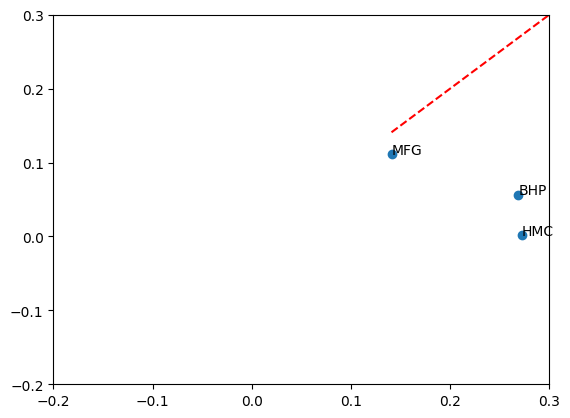

In [17]:
import matplotlib.pyplot as plt
compare = pd.concat([pd.DataFrame(pre_25_ic).iloc[3], pd.DataFrame(post_25_ic).iloc[3]], axis=1)
compare.columns = ['pre','post']

plt.scatter(compare['pre'], compare['post'])
plt.plot([compare['pre'].min(), compare['pre'].max()], [compare['pre'].min(), compare['pre'].max()], 'r--')
plt.xlim([-0.2, 0.3])
plt.ylim([-0.2, 0.3])
# labeling each point
for i, txt in enumerate(compare.index):
    plt.annotate(txt, (compare['pre'][i], compare['post'][i]))

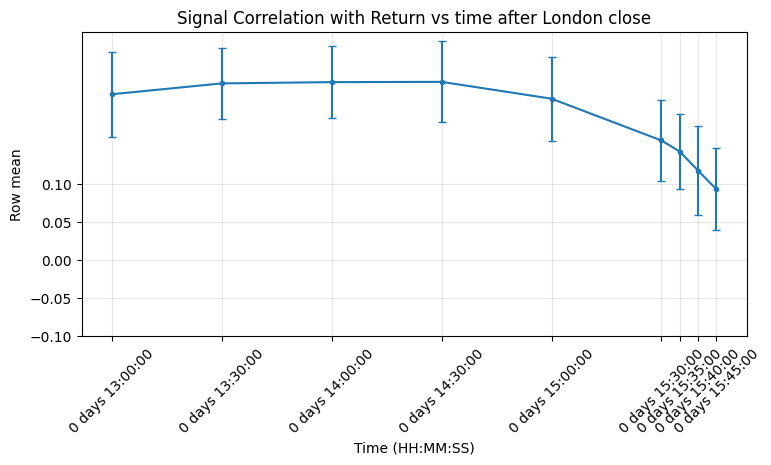

In [18]:
import seaborn as sns

df = pd.DataFrame(all_hedged_ic)
df.index = pd.to_timedelta(measured_time)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# --- Assume df is your DataFrame ---
# Rows = times (TimedeltaIndex), columns = series you want to average per row
# Example dtype check (optional):

# 1) Row-wise statistics
row_mean = df.mean(axis=1)                # average of each row
row_err  = df.std(axis=1, ddof=1)         # error bars = row-wise std
# If you prefer standard error of the mean (SEM), use:
# row_err = df.std(axis=1, ddof=1) / np.sqrt(df.shape[1])

# 2) Convert TimedeltaIndex to numeric (nanoseconds) for robust formatting
x_ns = df.index.values.astype('timedelta64[ns]').astype('int64')

# 3) Plot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x_ns, row_mean.values, yerr=row_err.values,
    fmt='-o', linewidth=1.5, capsize=3, markersize=3
)

# 4) Format x-axis to show HH:MM:SS (drop fractional seconds). Adjust to taste.
def td_formatter(v, pos):
    # v is in nanoseconds
    s = str(pd.to_timedelta(int(v), unit='ns'))
    return s.split('.')[0]  # strip fractional seconds like '00:01:23.456789'

ax.xaxis.set_major_formatter(FuncFormatter(td_formatter))
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))

ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Row mean")
ax.set_title("Signal Correlation with Return vs time after London close")

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.10])
ax.set_xticks(x_ns)
ax.set_xticklabels([str(td).split('.')[0] for td in df.index])  # format HH:MM:SS
plt.show()


In [ ]:
all_sig = pd.read_parquet(os.path.join(signal_dir)).reset_index().pivot(index='index',
                                        columns='ticker',
                                        values='signal'
                                    )

In [ ]:
all_sig.loc['2025-05-01':].loc[:]

ticker,AEG,ARGX,ASML,AZN,BBVA,BCS,BP,BTI,BUD,DB,...,SAN,SAP,SHEL,SNN,SNY,TS,TTE,UL,VOD,WPP
index,,,,,,,,,,,,,,,,,,,,,
2025-01-02 11:29:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 11:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 11:31:00-05:00,-0.002653,-0.001146,-0.000842,-0.000187,-0.001357,-0.001384,0.000450,0.000680,0.000496,0.000100,...,0.000914,0.000152,0.000303,-0.001390,0.000389,0.001245,0.002562,-0.001150,0.000589,-0.004306
2025-01-02 11:32:00-05:00,-0.003014,-0.001290,-0.000833,-0.000120,-0.001864,-0.000512,0.000538,0.001277,0.000970,0.000284,...,0.000420,0.000024,0.000537,0.000080,0.000329,0.001150,0.002448,-0.000928,0.000659,-0.003741
2025-01-02 11:33:00-05:00,-0.000430,-0.001116,0.000843,0.000624,-0.000604,0.001017,0.001712,0.001928,0.001230,0.001269,...,0.001646,0.000809,0.001705,0.000503,0.000425,0.001847,0.002911,-0.000498,0.001588,-0.002702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 15:55:00-05:00,-0.001744,0.009965,0.012944,-0.008647,-0.001413,0.002238,0.005086,-0.003295,-0.001065,0.002479,...,-0.000576,-0.003094,0.001358,-0.004730,0.003271,-0.001379,0.001712,-0.001476,0.003197,0.003628
2025-11-04 15:56:00-05:00,-0.001773,0.010538,0.013472,-0.008975,-0.000948,0.002759,0.005683,-0.003092,-0.000757,0.003559,...,0.000373,-0.003188,0.002060,-0.005110,0.004465,-0.001653,0.001940,-0.001297,0.003221,0.004223
2025-11-04 15:57:00-05:00,-0.001499,0.010896,0.015684,-0.008980,-0.001149,0.002914,0.005498,-0.003240,0.000018,0.004347,...,0.000741,-0.002984,0.002141,-0.005573,0.005628,-0.000682,0.002007,-0.001420,0.003291,0.003759


In [20]:
all_sig

,signal,ticker
2020-01-02 11:31:00-05:00,0.000417,AEG
2020-01-02 11:32:00-05:00,0.000405,AEG
2020-01-02 11:33:00-05:00,0.000369,AEG
2020-01-02 11:34:00-05:00,0.000000,AEG
2020-01-02 11:35:00-05:00,-0.000333,AEG
...,...,...
2025-11-04 15:55:00-05:00,0.003628,WPP
2025-11-04 15:56:00-05:00,0.004223,WPP
2025-11-04 15:57:00-05:00,0.003759,WPP
2025-11-04 15:58:00-05:00,0.003415,WPP


In [ ]:
import os
import pandas as pd